In [1]:
from cpc_pipeline import *

import nltk
import random

from llm import LLM
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

In [2]:
filtered_corpus = [s for s in nltk.corpus.abc.words() if s.lower() == s]
def make_caesar_cipher(word_length):
    word = random.choice([s for s in filtered_corpus if len(s) == word_length])
    shift = random.randint(1, 25)
    return ''.join([chr((ord(c) + shift - 97) % 26 + 97) for c in word])

def solve_caesar_gpt35t(problem, prompt=None):
    if prompt is None:
        prompt = "This ciphertext is either an anagram or a Caesar cipher. First, assume it's an anagram, and try to unscramble it. If that doesn't work, assume it's a Caesar cipher and try to decrypt it. Ciphertext: {ciphertext}"
    return gpt35t.chat_completion(prompt.format(ciphertext=problem))

from new_switch_utils import make_non_decreasing

anagram_switching_prompt = "This is a reasoning transcript of an agent trying to decipher some ciphertext. The agent will start treating the ciphertext as an anagram and attempting to unscramble it. The agent may then give up and treat the ciphertext as a Caesar cipher instead. First you will be shown the full transcript, then just a prefix of the transcript. By the end of the prefix transcript, has the agent switched from treating the ciphertext as an anagram to treating it as a Caesar cipher yet?"
def judge_anagram_switching(context, prefix):
        return 1 if gpt4.yesno_completion(anagram_switching_prompt+'\n\nFULL TRANSCRIPT:\n'+context+'\n\nPREFIX TRANSCRIPT:\n'+prefix+"\n\nANSWER:\n") == 'Yes' else 0

def split_and_judge_gpt4(context, chunk_size):
    prefixes = [context[:pref_end] for pref_end in range(chunk_size, len(context)+chunk_size, chunk_size)]
    measured_switching = [judge_anagram_switching(context, prefix) for prefix in prefixes]
    processed_switching = random.choice(make_non_decreasing(measured_switching))
    return prefixes, processed_switching

anagram_cpc_prompt = """At this point, we're going to stop and consider whether this approach is working or not 
              and leads to a correct solution to the problem being worked on. 
              Otherwise, we should step back and try a different approach."""

from solver import perform_one_token_cpc, perform_cot_cpc
def gpt35t_1t(context):
    return perform_one_token_cpc(gpt35t, context, prompt=anagram_cpc_prompt)
def gpt35t_cot(context):
    return perform_cot_cpc(gpt35t, context, prompt=anagram_cpc_prompt)
def gpt4_1t(context):
    return perform_one_token_cpc(gpt4, context, prompt=anagram_cpc_prompt)
def gpt4_cot(context):
    return perform_cot_cpc(gpt4, context, prompt=anagram_cpc_prompt)

Reading cpc_pipeline/make_caesar_cipher4292471679_10.csv...
Reading cpc_pipeline/solve_caesar_gpt35t645059983.csv...
Reading cpc_pipeline/split_and_judge_gpt43159090875.csv...
Reading cpc_pipeline/cpc_4742985.csv...


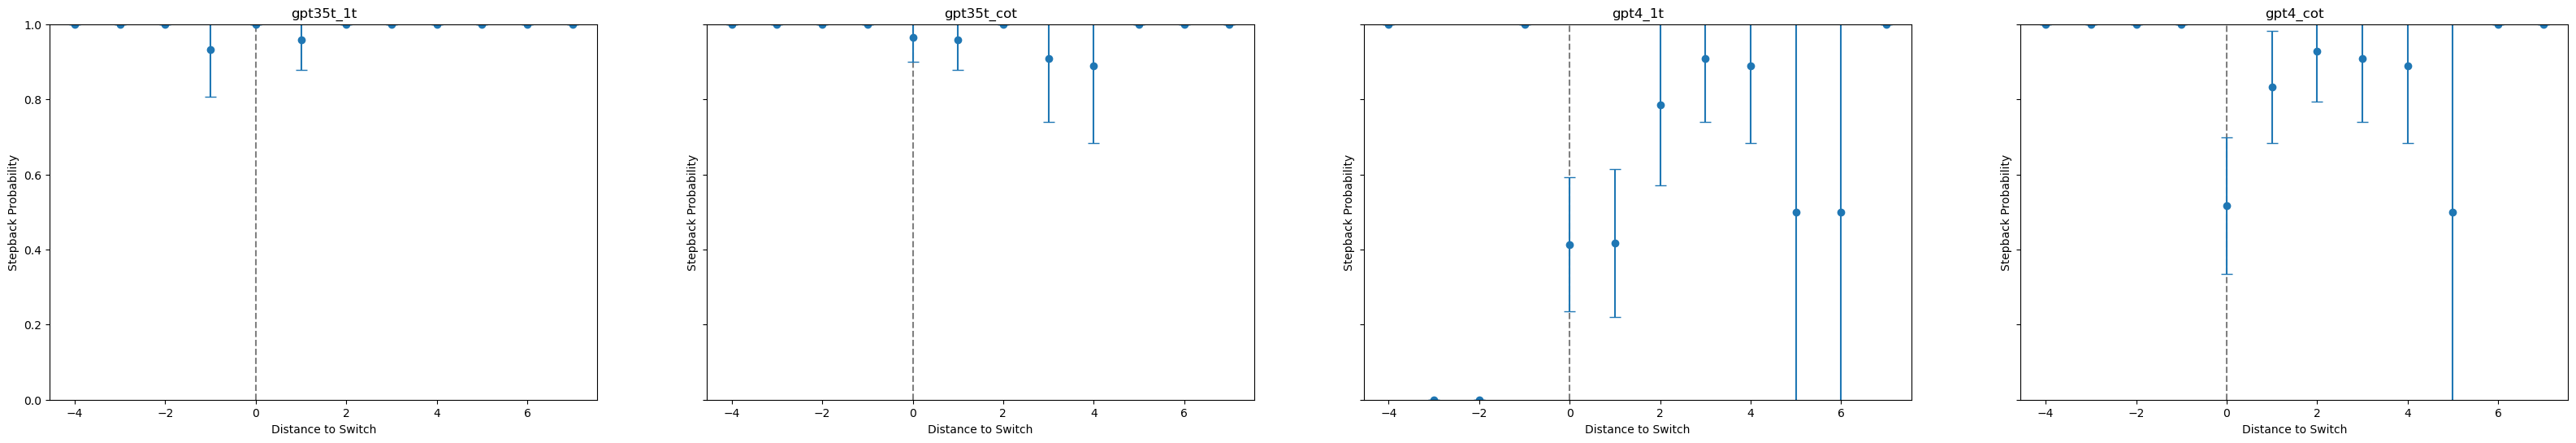

In [3]:
problem_df = cpc_problems(make_caesar_cipher, {'word_length': [5, 6, 7]}, n=10)
context_df = cpc_contexts(problem_df, solve_caesar_gpt35t)
switching_df = split_and_judge_switching(context_df, split_and_judge_gpt4, 100)
cpc_df = judge_cpc(switching_df, [gpt35t_1t, gpt35t_cot, gpt4_1t, gpt4_cot])
do_analysis(cpc_df, [gpt35t_1t, gpt35t_cot, gpt4_1t, gpt4_cot])